In [19]:
from pandas.plotting import lag_plot
from pandas.plotting import autocorrelation_plot
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,GRU, Dense, Bidirectional
from tensorflow.keras.layers import SimpleRNN, Dense
from tensorflow.keras.layers import TimeDistributed, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

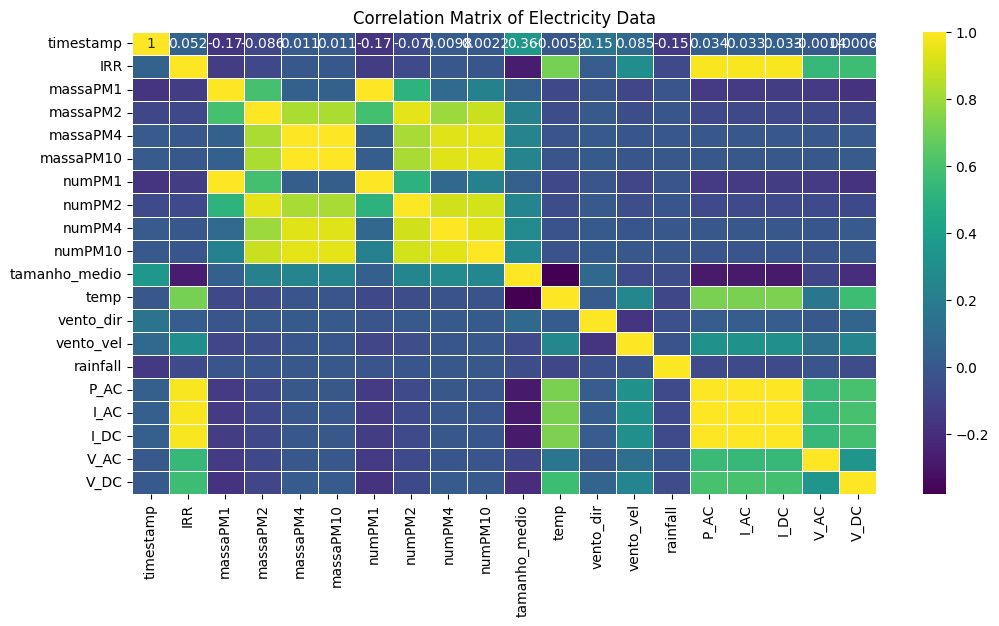

In [20]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Read the CSV data (assuming it's saved as 'data.csv')
df = pd.read_csv('train_valid_data.csv', parse_dates=['timestamp'])



plt.figure(figsize=(12, 6))
corr = df.corr()
sns.heatmap(corr, annot=True, cmap='viridis', linewidths=0.5)

plt.title('Correlation Matrix of Electricity Data')
plt.show()


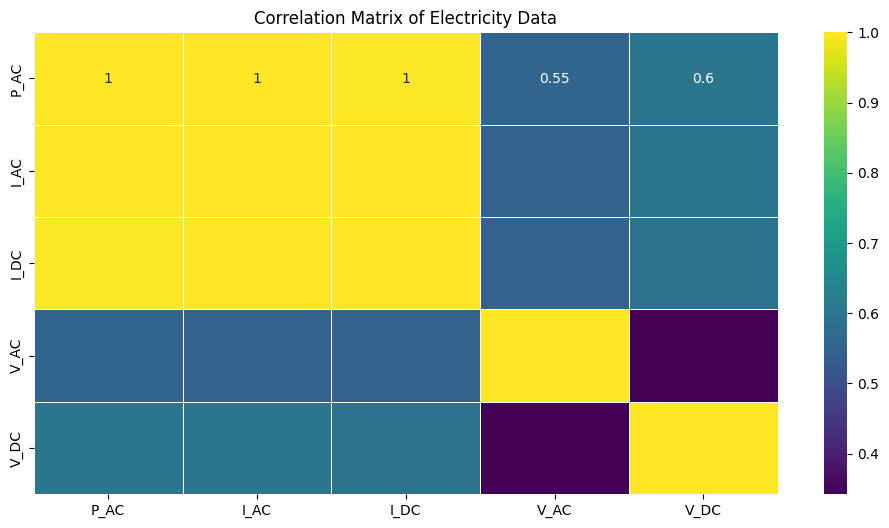

In [21]:
filtered_df = df[['P_AC', 'I_AC', 'I_DC', 'V_AC', 'V_DC']]

plt.figure(figsize=(12, 6))
corr = filtered_df.corr()
sns.heatmap(corr, annot=True, cmap='viridis', linewidths=0.5)

plt.title('Correlation Matrix of Electricity Data')
plt.show()

since correlation is super high so we cleaned some and the aim is to find the P_AC, V_AC and V_DC will cause data leakage.

In [22]:
df = df.drop(['I_AC','I_DC','V_AC','V_DC'], axis=1)

In [23]:
df.columns

Index(['timestamp', 'IRR', 'massaPM1', 'massaPM2', 'massaPM4', 'massaPM10',
       'numPM1', 'numPM2', 'numPM4', 'numPM10', 'tamanho_medio', 'temp',
       'vento_dir', 'vento_vel', 'rainfall', 'P_AC'],
      dtype='object')

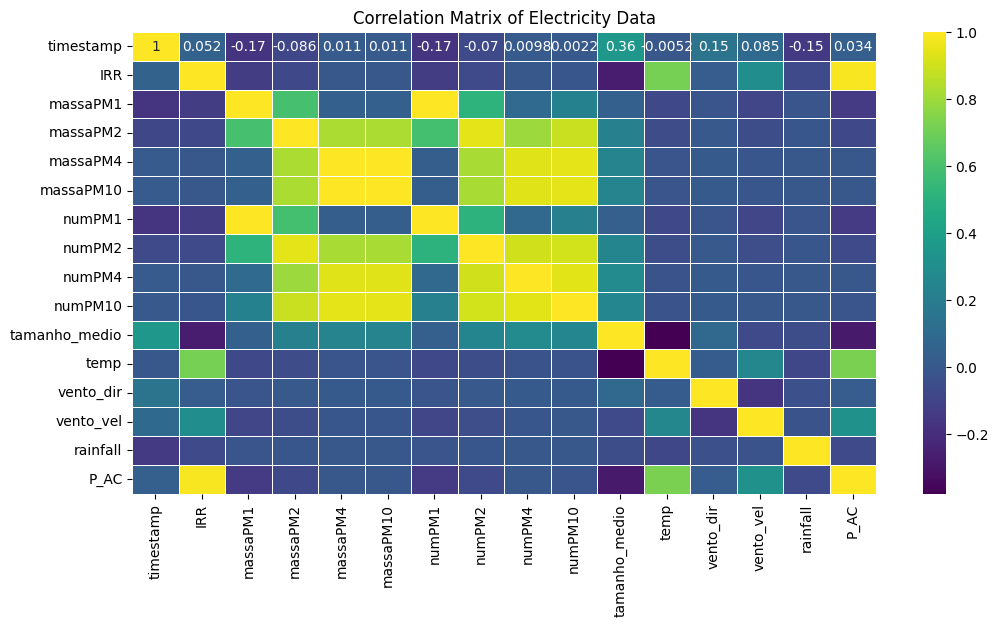

In [24]:
plt.figure(figsize=(12, 6))
corr = df.corr()
sns.heatmap(corr, annot=True, cmap='viridis', linewidths=0.5)

plt.title('Correlation Matrix of Electricity Data')
plt.show()

In [26]:
# Feature Engineering: Add time-based features
df['hour'] = pd.to_datetime(df['timestamp']).dt.hour
df['dayofweek'] = pd.to_datetime(df['timestamp']).dt.dayofweek

# Normalize the data
scaler = MinMaxScaler()
scaled_df = scaler.fit_transform(df[['IRR', 'massaPM1', 'massaPM2', 'massaPM4', 'massaPM10',
       'numPM1', 'numPM2', 'numPM4', 'numPM10', 'tamanho_medio', 'temp',
       'vento_dir', 'vento_vel', 'rainfall', 'P_AC', 'hour', 'dayofweek']])

# Convert to a DataFrame
scaled_df = pd.DataFrame(scaled_df, columns=['IRR', 'massaPM1', 'massaPM2', 'massaPM4', 'massaPM10',
       'numPM1', 'numPM2', 'numPM4', 'numPM10', 'tamanho_medio', 'temp',
       'vento_dir', 'vento_vel', 'rainfall', 'P_AC', 'hour', 'dayofweek'])

# Create sequences
def create_sequences(df, seq_length):
    sequences = []
    labels = []
    for i in range(len(df) - seq_length):
        seq = df.iloc[i:i+seq_length].values
        label = df['P_AC'].iloc[i+seq_length]
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels)

SEQ_LENGTH = 24  # for 24 hours sequence
sequences, labels = create_sequences(scaled_df, SEQ_LENGTH)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(sequences, labels, test_size=0.2, shuffle=False)

# Model Definition
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(SEQ_LENGTH, X_train.shape[2])),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')

# Callbacks for early stopping and learning rate reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)

# Model Training
history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.2, callbacks=[early_stopping, reduce_lr])

# Model Evaluation
predictions = model.predict(X_test)

# Calculate evaluation metrics
r2 = r2_score(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)

print(f'R² Score: {r2}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')

C:\Users\User\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
2765/2765 ━━━━━━━━━━━━━━━━━━━━ 32s 10ms/step - loss: 0.0138 - val_loss: 0.0113 - learning_rate: 0.0010
Epoch 2/30
2765/2765 ━━━━━━━━━━━━━━━━━━━━ 30s 11ms/step - loss: 0.0074 - val_loss: 0.0103 - learning_rate: 0.0010
Epoch 3/30
2765/2765 ━━━━━━━━━━━━━━━━━━━━ 30s 11ms/step - loss: 0.0069 - val_loss: 0.0104 - learning_rate: 0.0010
Epoch 4/30
2765/2765 ━━━━━━━━━━━━━━━━━━━━ 31s 11ms/step - loss: 0.0071 - val_loss: 0.0104 - learning_rate: 0.0010
Epoch 5/30
2765/2765 ━━━━━━━━━━━━━━━━━━━━ 32s 11ms/step - loss: 0.0067 - val_loss: 0.0103 - learning_rate: 0.0010
Epoch 6/30
2765/2765 ━━━━━━━━━━━━━━━━━━━━ 32s 11ms/step - loss: 0.0066 - val_loss: 0.0103 - learning_rate: 0.0010
Epoch 7/30
2765/2765 ━━━━━━━━━━━━━━━━━━━━ 33s 12ms/step - loss: 0.0065 - val_loss: 0.0103 - learning_rate: 0.0010
Epoch 8/30
2765/2765 ━━━━━━━━━━━━━━━━━━━━ 28s 10ms/step - loss: 0.0065 - val_loss: 0.0103 - learning_rate: 5.0000e-04
Epoch 9/30
2765/2765 ━━━━━━━━━━━━━━━━━━━━ 28s 10ms/step - loss: 0.0068 - val_loss: 0

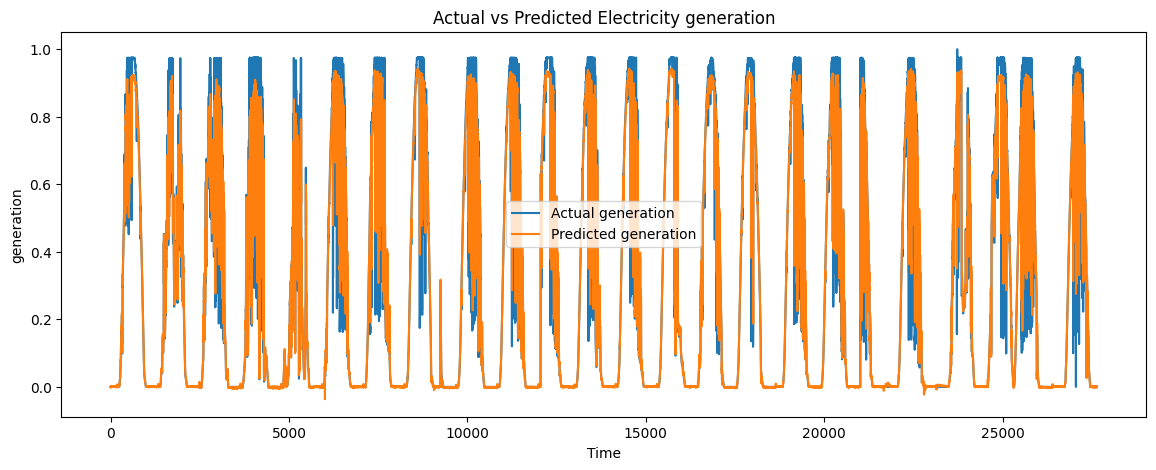

In [27]:
# Plot predictions vs actual values
plt.figure(figsize=(14, 5))
plt.plot(y_test, label='Actual generation')
plt.plot(predictions, label='Predicted generation')
plt.title('Actual vs Predicted Electricity generation')
plt.xlabel('Time')
plt.ylabel('generation')
plt.legend()
plt.show()

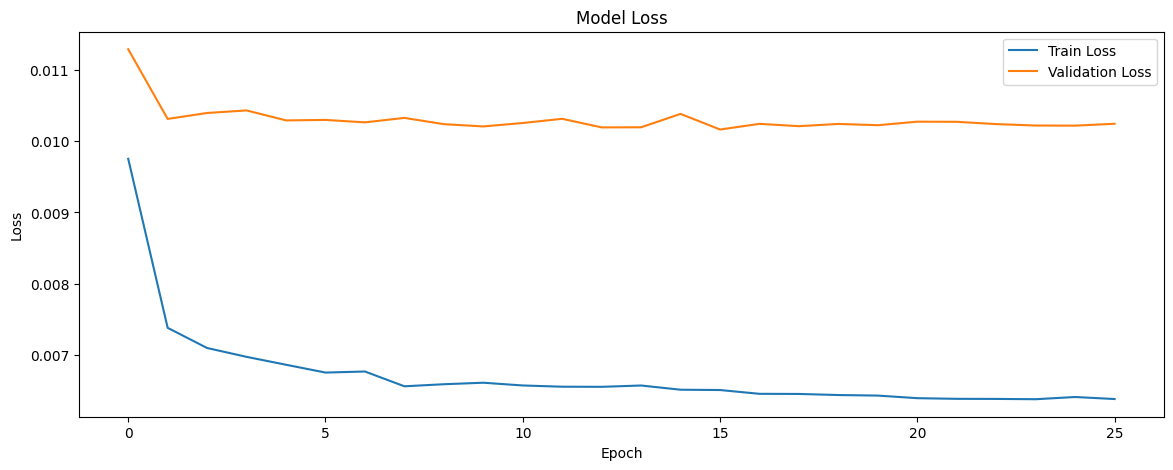

In [28]:
plt.figure(figsize=(14, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()